In [1]:
### Importing the basic modules

#### First part: Analysis and data pre-processing
import os           # Working directory
import pandas as pd # Data processing
import matplotlib
import matplotlib.pyplot as plt # Common graphing interface (check also plotly and plotnine)

#### Second part: models and Hyperparameter optimization
import tensorflow as tf
import keras 
import numpy as np
from functools import partial

from keras.activations import relu, softmax 
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Activation, BatchNormalization, Concatenate, concatenate, Dense, Dropout, Input, InputLayer, Lambda, LeakyReLU
from keras.layers.merge import _Merge
from keras.losses import mse, binary_crossentropy, categorical_crossentropy, mean_squared_error
import keras.metrics as metrics
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

#### Extra
import random as rn

# Personal modules
import TUutils
import validationUtils
import plotUtils
from models import VAE, WGAN

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Random number seeds
np.random.seed(42) # Numpy
rn.seed(12345) # Python
tf.set_random_seed(1234) # TenforFlow

In [4]:
# prevent tensorflow from allocating the entire GPU memory at once
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#"""
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
#session = tf.Session(config=config)
#"""
set_session(tf.Session(config=config))

In [5]:
### Changing the working directory
#os.chdir('C:/Users/shgm/Desktop/projects/job_VAE') # PC
#os.chdir('/mnt/sdb1/data_shgm/') # Server 32
print(os.getcwd())

/home/shgm/JobPopSynth


In [6]:
# Load the data
samp_df = pd.read_csv('TU_CPH_Sample_CourseSlim.csv', sep=',')

In [7]:
print(samp_df.shape)

(55673, 45)


In [8]:
# Variables to drop
DELETE = ['SessionID', 'JourneyID', 'HomeZoneID', 'HomeZoneID0', 'HomeZoneID2', 'PrimOccNTMZone', 'SessionWeight', 'OrigZoneID', 'OrigZoneID2', 'DestZoneID', 'DestZoneID2', 'RespAgeCorrect']
samp_df.drop(DELETE, axis=1, inplace=True)
samp_df.dropna(inplace=True)

In [9]:
CATEGORICAL = ['DiaryYear', 'DiaryWeekday', 'ZID', 'CategoryID', 'ModeID', 'Male', 'RespPrimOcc', 'RespEdulevel', 'IncomeID', 'HHIncomeID', 'SingleID', 'LMA', 'HousehNumCars', 'HousehAccomodation', 
'HousehAccOwnorRent', 'PosInFamily', 'FamNumPers', 'FamNumAdults', 'FamNumPers1084', 'FamNumDrivLic', 'Children', 'SpaceID', 'AgeGroup', 'WorkParkPoss']
CATEGORICAL_TYPES = {key:value for (key,value) in zip(CATEGORICAL, ['category']*len(CATEGORICAL))}

NUMERICAL = ['TotalLen', 'WorkHoursPw', 'IncomeP', 'IncomeF', 'IncomeS', 'LicenseYears', 'DepartureMsm', 'JStartTimeMsm', 'PrimTargetDweltime']
NUMERICAL_TYPES = {key:value for (key,value) in zip(NUMERICAL, ['int32']*len(NUMERICAL))}

D_TYPES = {**CATEGORICAL_TYPES, **NUMERICAL_TYPES}

In [10]:
samp_df = samp_df.astype(D_TYPES)

In [11]:
numerical_col_n = len(NUMERICAL) # Number of numerical variable
categorical_col_n = len(CATEGORICAL) # Number of categorical variables

categories_n = [] # Number of categories in each categorical variable
for cat in CATEGORICAL:
    categories_n.append(len(samp_df[cat].cat.categories)) 
categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
categories_cum = [0] + categories_cum

# Sort the dataset columns
samp_df = samp_df.reindex(NUMERICAL+CATEGORICAL, axis=1)

In [13]:
BINNING=True
train, test, validation, pre_one_hot_df, one_hot_df, col_names = TUutils.data_creator(samp_df, numerical=NUMERICAL, train_prop=0.82, val_prop=0.2, binning=BINNING, condition_on=None) # , quantiles=5 if dim too big

n_inputs = train.shape[1]

Train shape is: (36000, 340)
Validation shape is: (9000, 340)
Test shape is: (9879, 340)


In [14]:
# Re-Definition of global lists for numerical and categorical variables. This is only ran iff we binned the numerical variables 
if BINNING: 
    NUMERICAL = []
    numerical_col_n = len(NUMERICAL) # Number of numerical variable

    CATEGORICAL = [col for col in list(pre_one_hot_df) if col not in NUMERICAL]
    pre_one_hot_df[CATEGORICAL] = pre_one_hot_df[CATEGORICAL].astype('category')
    categorical_col_n = len(CATEGORICAL) # Number of categorical variables
    categories_n = [] # Number of categories in each categorical variable
    for cat in CATEGORICAL:
        categories_n.append(len(pre_one_hot_df[cat].cat.categories)) 
    categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
    categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
    categories_cum = [0] + categories_cum

In [15]:
assert  all(val<100 for (n, val) in enumerate(categories_n))

In [16]:
for i in zip(CATEGORICAL, categories_n):
    print(i)

('TotalLen', 13)
('WorkHoursPw', 8)
('IncomeP', 13)
('IncomeF', 14)
('IncomeS', 13)
('LicenseYears', 11)
('DepartureMsm', 13)
('JStartTimeMsm', 13)
('PrimTargetDweltime', 13)
('DiaryYear', 14)
('DiaryWeekday', 5)
('ZID', 32)
('CategoryID', 9)
('ModeID', 7)
('Male', 2)
('RespPrimOcc', 16)
('RespEdulevel', 11)
('IncomeID', 11)
('HHIncomeID', 12)
('SingleID', 2)
('LMA', 7)
('HousehNumCars', 12)
('HousehAccomodation', 6)
('HousehAccOwnorRent', 3)
('PosInFamily', 4)
('FamNumPers', 12)
('FamNumAdults', 9)
('FamNumPers1084', 13)
('FamNumDrivLic', 9)
('Children', 9)
('SpaceID', 3)
('AgeGroup', 10)
('WorkParkPoss', 11)


## VAE

In [27]:
_VAE = VAE(train=train, validation=validation, numerical_col_n=numerical_col_n, 
           categorical_col_n=categorical_col_n, categories_n=categories_n, 
           categories_cum=categories_cum, 
           eval_set=['ZID', 'Male', 'AgeGroup', 'IncomeID'] , 
           col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
            intermediate_dim=1024, latent_dim=100, n_hidden_layers=1, drop_rate=0.25,# Architecture
            cat_loss_weight=None, beta=0.0025, # Loss
            batch_size=90, epochs=100, learn_rate=0.0007)  # Train: 11 x 31 x 89 353 Validation: 5 x 13 x 17 x 23

_VAE.vae_evaluate()
# MAE:0.00012008953465574746, MSE:8.42295075693742e-08, RMSE:0.00029022320301687495, SRSME:1.364919723788363 with 1024

Train on 36000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 44.1886 - val_loss: 29.0990
Epoch 2/100
 - 6s - loss: 30.9179 - val_loss: 24.3982
Epoch 3/100
 - 6s - loss: 27.6894 - val_loss: 22.6161
Epoch 4/100
 - 6s - loss: 26.2388 - val_loss: 21.7115
Epoch 5/100
 - 6s - loss: 25.4336 - val_loss: 21.1034
Epoch 6/100
 - 6s - loss: 24.9032 - val_loss: 20.7553
Epoch 7/100
 - 6s - loss: 24.4228 - val_loss: 20.3427
Epoch 8/100
 - 6s - loss: 24.1264 - val_loss: 20.1867
Epoch 9/100
 - 6s - loss: 23.8413 - val_loss: 19.8712
Epoch 10/100
 - 6s - loss: 23.5765 - val_loss: 19.6951
Epoch 11/100
 - 6s - loss: 23.3477 - val_loss: 19.4466
Epoch 12/100
 - 6s - loss: 23.1037 - val_loss: 19.3048
Epoch 13/100
 - 6s - loss: 22.9396 - val_loss: 19.1970
Epoch 14/100
 - 6s - loss: 22.7757 - val_loss: 19.0200
Epoch 15/100
 - 6s - loss: 22.6129 - val_loss: 18.9086
Epoch 16/100
 - 6s - loss: 22.4698 - val_loss: 18.7346
Epoch 17/100
 - 6s - loss: 22.3625 - val_loss: 18.6305
Epoch 18/100
 - 6s - loss

0.00027445589919816726

In [28]:
_VAE.n_samples = 500000
vae_n  = TUutils.samples_to_df(_VAE.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)

MAE:0.00012307351322264498, MSE:9.24366337000168e-08, RMSE:0.000304033935112541, SRSME:1.434736139796081
corr = 0.909517
MAE = 0.000123
RMSE = 0.000304
SRMSE = 1.434736
r2 = 0.800199


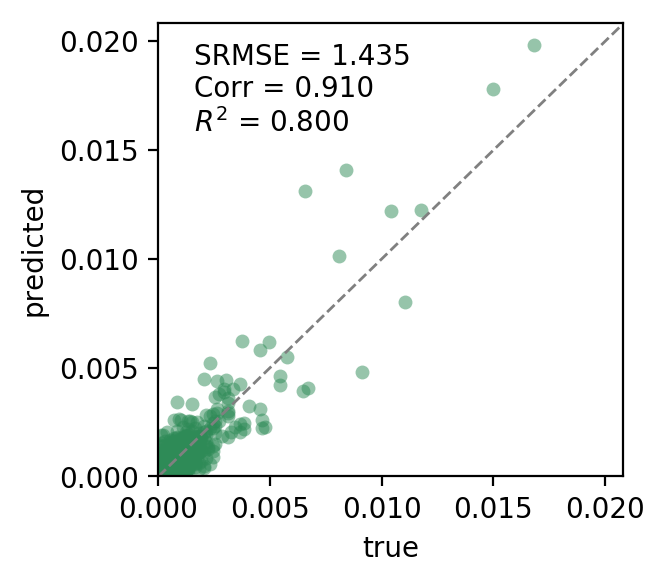

In [29]:
eval_set = ['ZID', 'Male', 'AgeGroup', 'IncomeID'] 
_ = validationUtils.evaluate(real=test, model=vae_n, agg_vars=eval_set, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [30]:
vae_n.to_csv(r'/home/shgm/JobPopSynth/VAE_samples_class.csv', index = None, header=True)

## WGAN

In [31]:
epochs_WGAN = 10000
wgan_latent_dim = 100
_WGAN = WGAN(train=train, validation=validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['ZID', 'Male', 'AgeGroup', 'IncomeID'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=1024, latent_dim=wgan_latent_dim, n_hidden_layers_gen=1, # Generator architecture 
             intermediate_dim_crit=1024, n_hidden_layers_crit=1, # Critic architecture 
             batch_size=256, epochs=epochs_WGAN, gen_learn_rate=1.51986904e-04,
             crit_learn_rate=1.51986904e-04 , clip_value=0.01, nCritic=5) 
_WGAN.wgan_evaluate()

/home/shgm/py3/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: -0.010426, acc.: 0.00%] [G loss: 0.007712]
100 [D loss: -0.112903, acc.: 0.00%] [G loss: -0.011721]
200 [D loss: -0.069197, acc.: 0.39%] [G loss: -0.226696]
300 [D loss: -0.092525, acc.: 12.30%] [G loss: -0.262382]
400 [D loss: -0.041227, acc.: 6.05%] [G loss: -0.401425]
500 [D loss: -0.055930, acc.: 0.00%] [G loss: -0.255486]
600 [D loss: -0.074458, acc.: 0.00%] [G loss: -0.192338]
700 [D loss: -0.045531, acc.: 0.78%] [G loss: -0.218991]
800 [D loss: -0.009139, acc.: 2.54%] [G loss: -0.253499]
900 [D loss: -0.032311, acc.: 0.00%] [G loss: -0.153071]
1000 [D loss: -0.043540, acc.: 0.00%] [G loss: -0.114913]
1100 [D loss: -0.041420, acc.: 0.00%] [G loss: -0.105420]
1200 [D loss: -0.041388, acc.: 0.00%] [G loss: -0.099988]
1300 [D loss: -0.028429, acc.: 0.00%] [G loss: -0.113236]
1400 [D loss: -0.039306, acc.: 0.00%] [G loss: -0.088525]
1500 [D loss: -0.029151, acc.: 0.00%] [G loss: -0.087671]
1600 [D loss: -0.027423, acc.: 0.00%] [G loss: -0.079756]
1700 [D loss: -0.026998, a

0.00022203734516546494

In [35]:
_WGAN.epochs = 10000
_WGAN.wgan_fit()

0 [D loss: -0.006376, acc.: 0.00%] [G loss: -0.031032]
100 [D loss: -0.005694, acc.: 0.00%] [G loss: -0.031587]
200 [D loss: -0.005373, acc.: 0.00%] [G loss: -0.032266]
300 [D loss: -0.005177, acc.: 0.00%] [G loss: -0.031203]
400 [D loss: -0.004905, acc.: 0.00%] [G loss: -0.030636]
500 [D loss: -0.005778, acc.: 0.00%] [G loss: -0.029917]
600 [D loss: -0.005820, acc.: 0.00%] [G loss: -0.030394]
700 [D loss: -0.005573, acc.: 0.00%] [G loss: -0.031134]
800 [D loss: -0.005509, acc.: 0.00%] [G loss: -0.030214]
900 [D loss: -0.004691, acc.: 0.00%] [G loss: -0.029949]
1000 [D loss: -0.005281, acc.: 0.00%] [G loss: -0.030039]
1100 [D loss: -0.005408, acc.: 0.00%] [G loss: -0.030426]
1200 [D loss: -0.005301, acc.: 0.00%] [G loss: -0.029508]
1300 [D loss: -0.005487, acc.: 0.00%] [G loss: -0.029494]
1400 [D loss: -0.004787, acc.: 0.00%] [G loss: -0.029685]
1500 [D loss: -0.005572, acc.: 0.00%] [G loss: -0.029227]
1600 [D loss: -0.004691, acc.: 0.00%] [G loss: -0.029814]
1700 [D loss: -0.005654, a

In [36]:
_WGAN.n_samples = 500000
wgan_n  = TUutils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)

MAE:8.52177663501803e-05, MSE:3.283648305824266e-08, RMSE:0.00018120839676527868, SRSME:0.8893708113239878
corr = 0.963248
MAE = 0.000085
RMSE = 0.000181
SRMSE = 0.889371
r2 = 0.926456


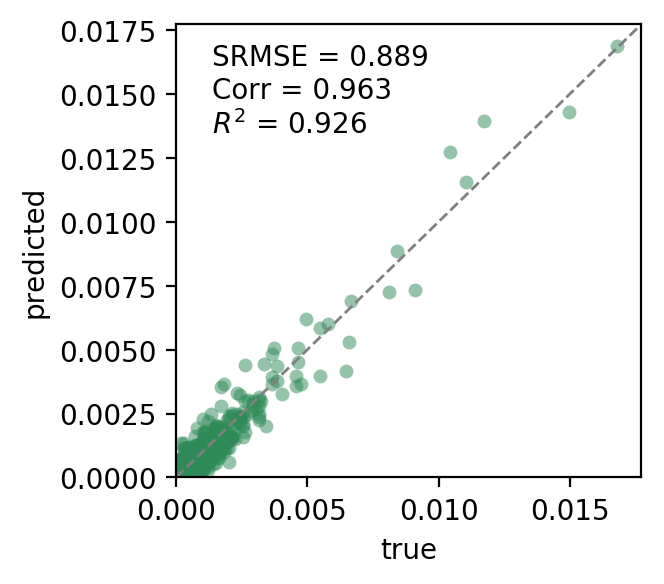

In [37]:
eval_set = ['ZID', 'Male', 'AgeGroup', 'IncomeID'] 
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=eval_set, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [38]:
wgan_n.to_csv(r'/home/shgm/JobPopSynth/WGAN_samples_class.csv', index = None, header=True)

In [6]:
# Load the data
samp_df = pd.read_csv('WGAN_samples_class.csv', sep=',')

In [7]:
samp_df.head()

,AgeGroup,CategoryID,Children,DepartureMsm,DiaryWeekday,DiaryYear,FamNumAdults,FamNumDrivLic,FamNumPers,FamNumPers1084,HHIncomeID,HousehAccOwnorRent,HousehAccomodation,HousehNumCars,IncomeF,IncomeID,IncomeP,IncomeS,JStartTimeMsm,LMA,LicenseYears,Male,ModeID,PosInFamily,PrimTargetDweltime,RespEdulevel,RespPrimOcc,SingleID,SpaceID,TotalLen,WorkHoursPw,WorkParkPoss,ZID,count
0,5,4,0.0,"(930.0, 960.0]",3,2010,3.0,2.0,3.0,2.0,7,3.0,3.0,0.0,"(600.0, 690.0]",3,"(189.0, 240.0]","(300.0, 348.0]","(840.0, 930.0]",2.0,"(5.0, 11.0]",1,2,11.0,"(25.0, 50.0]",11,210,0,1,"(14.0, 18.0]","(32.0, 35.0]",11,1,1
1,9,5,0.0,"(795.0, 840.0]",4,2012,1.0,0.0,1.0,1.0,2,2.0,3.0,1.0,"(-0.001, 166.0]",2,"(60.0, 120.0]","(-1.001, 0.0]","(720.0, 840.0]",4.0,"(50.0, 85.0]",0,4,10.0,"(50.0, 85.0]",1,370,1,2,"(14.0, 18.0]","(35.0, 37.0]",12,13,1
2,2,0,3.0,"(-0.001, 620.0]",2,2014,3.0,2.0,5.0,5.0,10,1.0,1.0,2.0,"(1000.0, 1200.0]",0,"(-0.001, 60.0]","(750.0, 12700.0]","(-0.001, 400.0]",3.0,"(-0.001, 5.0]",0,0,20.0,"(-0.001, 3.0]",1,107,0,3,"(-0.001, 2.0]","(35.0, 37.0]",11,24,1
3,6,2,1.0,"(840.0, 900.0]",1,2019,3.0,3.0,3.0,3.0,11,1.0,1.0,3.0,"(1200.0, 15000.0]",5,"(438.0, 500.0]","(488.0, 570.0]","(480.0, 510.0]",8.0,"(20.0, 24.0]",1,3,11.0,"(132.0, 200.0]",14,221,0,1,"(18.0, 24.0]","(48.0, 100.0]",13,1,1
4,6,0,1.0,"(-0.001, 620.0]",5,2018,3.0,0.0,3.0,3.0,8,1.0,3.0,0.0,"(690.0, 750.0]",5,"(438.0, 500.0]","(488.0, 570.0]","(-0.001, 400.0]",1.0,"(-0.001, 5.0]",0,0,12.0,"(-0.001, 3.0]",13,210,0,1,"(-0.001, 2.0]","(35.0, 37.0]",1,1,1
